In [1]:
from dataset.dataset import *
from torch.utils.data import Dataset, DataLoader
import getpass
import os
import socket
import numpy as np
from dataset.preprocess_data import *
from PIL import Image, ImageFilter
import argparse
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from models.model import generate_model
from opts import parse_opts
from torch.autograd import Variable
import time
import sys
from utils import *
import os.path as osp
import mmcv

from sklearn.decomposition import PCA
import torch.nn.functional as F
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid


In [2]:
class dummy():
    annotation_path = "dataset/HMDB51/"
    frame_dir = "dataset/HMDB51_labels"
    dataset = 'HMDB51'
    split = 1
    modality = 'RGB'
    input_channels = 3
    n_classes = 400
    n_finetune_classes = 51
    only_RGB = True
    output_layers = []
    model = 'resnext'
    model_depth = 101
    resnet_shortcut = 'B'
    resnext_cardinality = 32
    ft_begin_index = 4
    sample_size = 112
    sample_duration = 16
    freeze_BN = False
    batch_size = 20
    n_workers = 4

    learning_rate = 0.1
    momentum = 0.9
    dampening = 0.9
    weight_decay = 1e-3
    nesterov = False
    optimizer = 'sgd'
    lr_patience = 10
    MARS_alpha = 50
    n_epochs = 400
    begin_epoch = 1

    result_path = ''
    MARS = False
    pretrain_path = ''
    MARS_pretrain_path = ''
    MARS_resume_path = ''
    resume_path1 = ''
    resume_path2 = ''
    resume_path3 = ''
    log = 1
    checkpoint = 2

    manual_seed = 1
    random_seed = 1
    
    arch = 'resnext-101'
    training = True


In [3]:
classes = []
with open('/scratch/tkg5kq/mmaction2/data/hmdb51/annotations/classInd.txt', 'r') as f:
    for line in f:
        label = line.split(' ')[1]
        classes.append(label.strip('\n'))

# Gradient Visualization for MARS

This notebook will contain a visualization of the MARS method and how it is learning the actions from the videos

## Spatio-temporal Representations

First we will look at the Spatio-temporal (ST) version of MARS. This is where modality is set to 'RGB'.

### Load Test Data and Dataloader

Preprocess the dataloader by loading the testing data. We will use HMDB51 as an example here with the first split and testing data.

In [4]:
opt = dummy()
opt.batch_size = 1
opt.n_classes = 51
opt.model = 'resnext'
opt.input_channels = 3
opt.frame_dir = "/scratch/tkg5kq/mmaction2/data/hmdb51/frames/"
opt.annotation_path = "/scratch/tkg5kq/mmaction2/data/hmdb51/annotations/"
model_path = '/scratch/tkg5kq/MARS/pretrained/MARS_orig/HMDB/'
opt.resume_path1 = os.path.join(model_path, 'RGB_HMDB51_16f.pth')
opt.output_layers = ['avgpool', 'layer4', 'layer3']
opt.training = 0

In [5]:
test_data   = HMDB51_test(split = 1, 
                          train = 0, 
                          opt = opt)
print("Length of train data = ", len(test_data))


Length of train data =  1530


Next prepare the dataloader with a batch size of 32. This will use the __gititem__ function from the HMDB51_test class creating random samplings of the frames.

In [32]:
test_dataloader = DataLoader(test_data, 
                             batch_size = opt.batch_size, 
                             shuffle=False, 
                             pin_memory = True, 
                             drop_last=True)
print("Length of test datatloader = ",len(test_dataloader))    


Length of test datatloader =  1530


Get the first batch from the dataloader for our visualization

In [54]:
batch = next(iter(test_dataloader))

### Load the ST Model

In [55]:
# Get model
with torch.no_grad():
    model, parameters = generate_model(opt)
    print('loading checkpoint {}'.format(opt.resume_path1))
    checkpoint = torch.load(opt.resume_path1)
    assert opt.arch == checkpoint['arch'], f'Arch needs to be {checkpoint["arch"]}'
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    # run model on generated batch
    x,y = batch
    out = model(x)

    names = ['predictions']
    names.extend(opt.output_layers)
    for element, name in zip(out, names):
        print(f'{name}: {element.shape}')

    pred5 = np.array(torch.mean(out[0], dim=0, keepdim=True).topk(5, 1, True)[1].cpu().data[0])
    print(f'Pred: {[classes[pred] for pred in pred5]}, Actual: {classes[y[0]]}')

loading checkpoint /scratch/tkg5kq/MARS/pretrained/MARS_orig/HMDB/RGB_HMDB51_16f.pth
predictions: torch.Size([1, 51])
avgpool: torch.Size([1, 2048])
layer4: torch.Size([1, 2048, 1, 4, 4])
layer3: torch.Size([1, 1024, 2, 7, 7])
Pred: ['brush_hair', 'handstand', 'smile', 'smoke', 'chew'], Actual: brush_hair


### Analyze the Layer 3 Output Overlayed with Heatmap

Squeeze the output to be of the size 112x112 (same as the image) and then overlay the image on top.

avgpool: torch.Size([1, 51])
layer4: torch.Size([1, 2048])
layer3: torch.Size([1, 2048, 1, 4, 4])


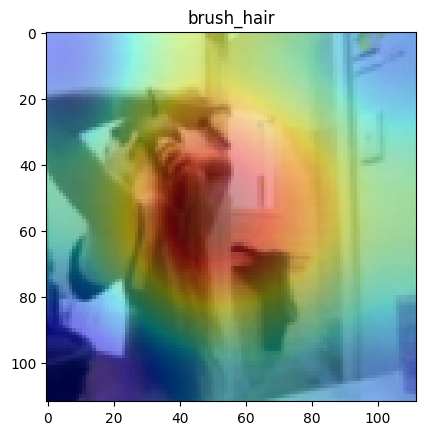

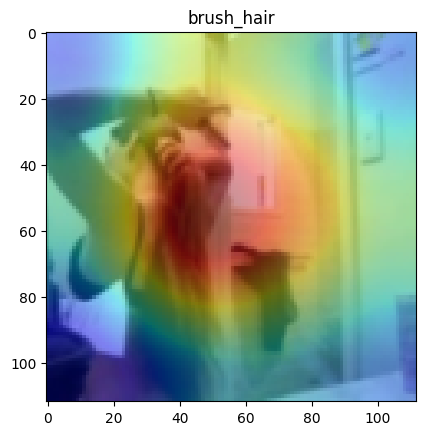

In [57]:
frame_num = -1
sample_num = 0

# Display the sizes of the layers
for i, output_layer in enumerate(opt.output_layers):
    print(f'{output_layer}: {out[i].shape}')

# https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
with torch.no_grad():
    data = out[2].cpu()[sample_num]

    # Interpolate from 4x4 to 112x112
    interp_data = F.interpolate(data, size=(112, 112), mode='bicubic', align_corners=False)
    # squeeze to just 4x4
    heatmap = torch.mean(interp_data, dim=(0,1)).squeeze()

    # Get the frame from the sample input and normalize
    perm_frames = x.permute(0, 2, 3, 4, 1)
    frame = perm_frames[sample_num, perm_frames.shape[1]//2]
    frame = frame.numpy()
    image = (frame-np.min(frame))/(np.max(frame)-np.min(frame))

    plt.figure()
    plt.title(f'{classes[y[sample_num]]}')
    plt.imshow(image)
    plt.imshow(heatmap, 'jet', interpolation='none', alpha=0.4)
    plt.show()

    # Get the frame from the sample input and normalize
    frame = x.permute(0, 2, 3, 4, 1)[sample_num, -1]
    frame = frame.numpy()
    image = (frame-np.min(frame))/(np.max(frame)-np.min(frame))

    plt.figure()
    plt.title(f'{classes[y[sample_num]]}')
    plt.imshow(image)
    plt.imshow(heatmap, 'jet', interpolation='none', alpha=0.4)
    plt.show()

### Visualize ST Sampling

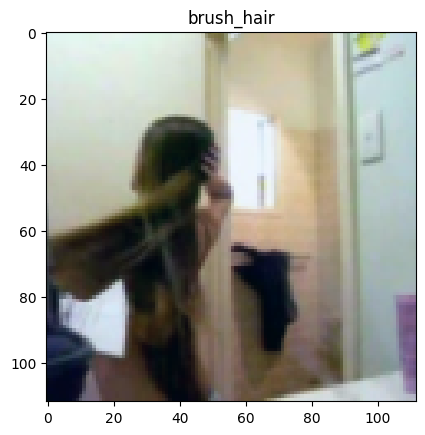

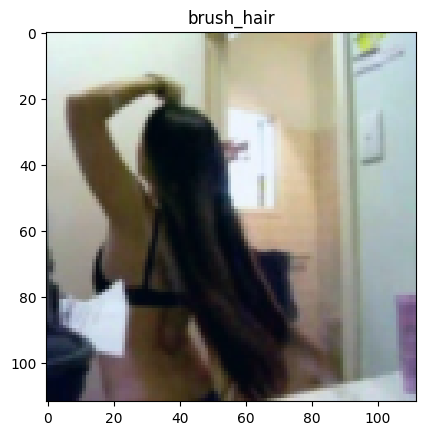

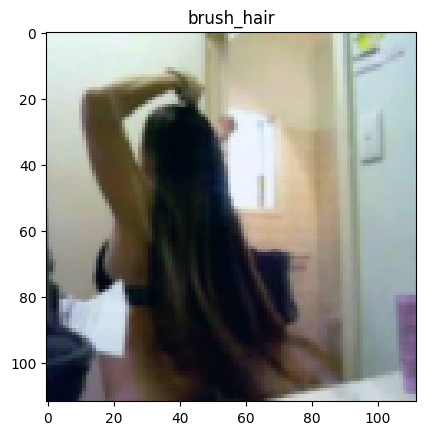

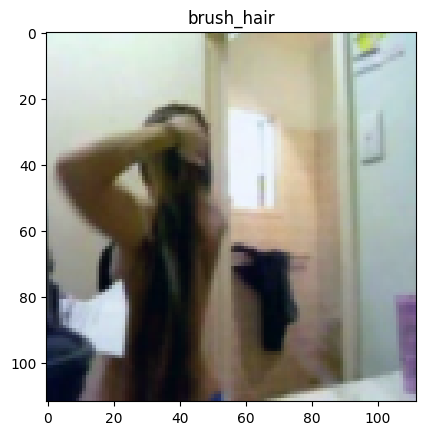

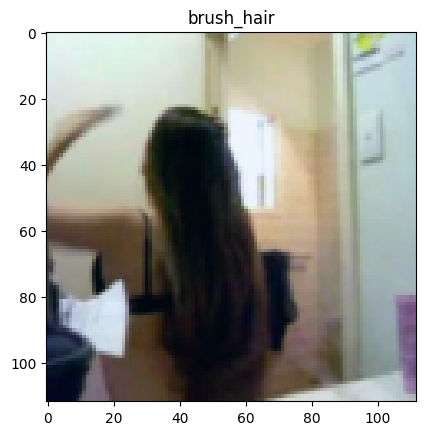

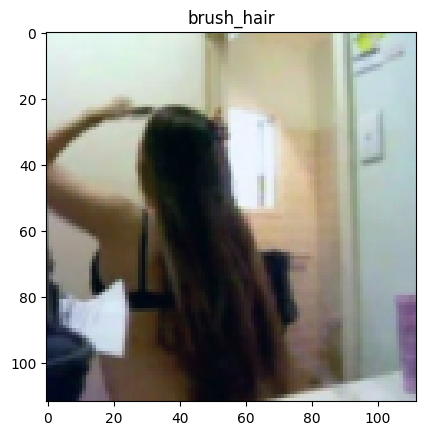

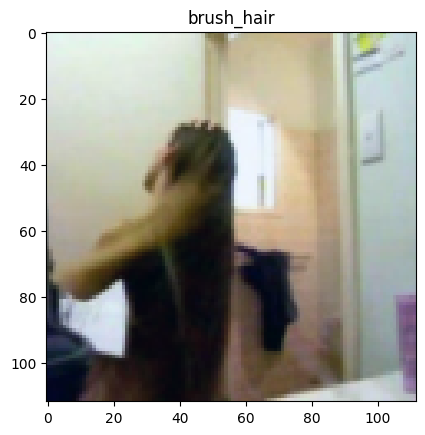

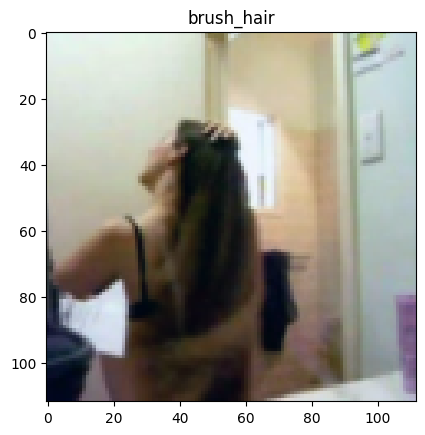

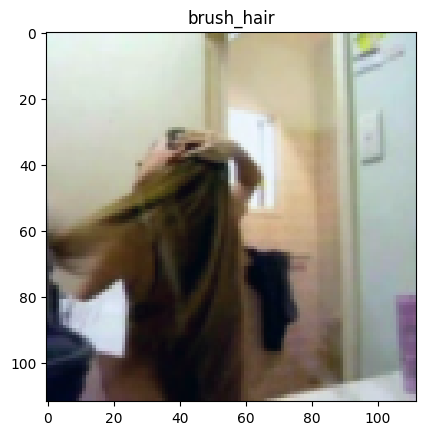

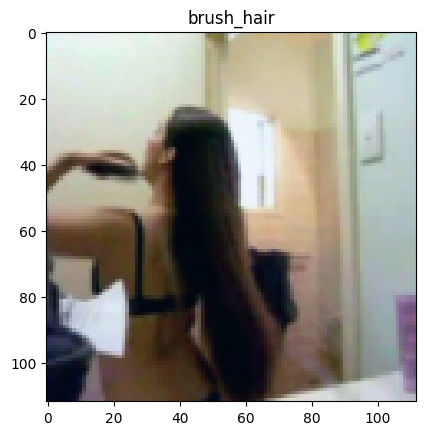

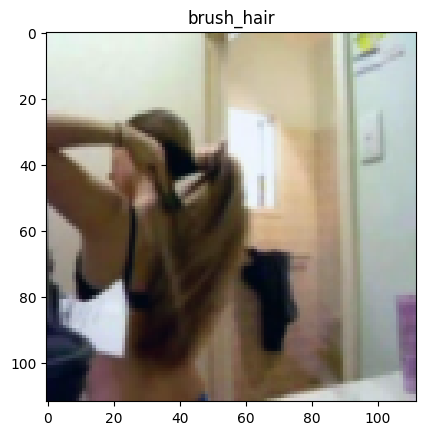

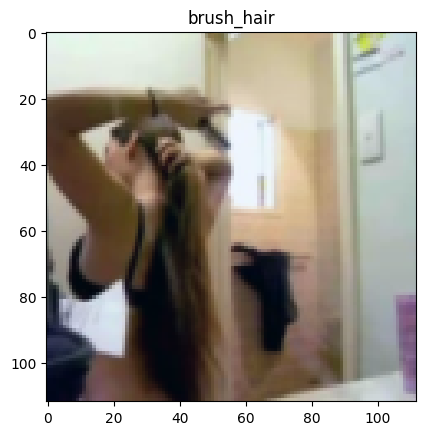

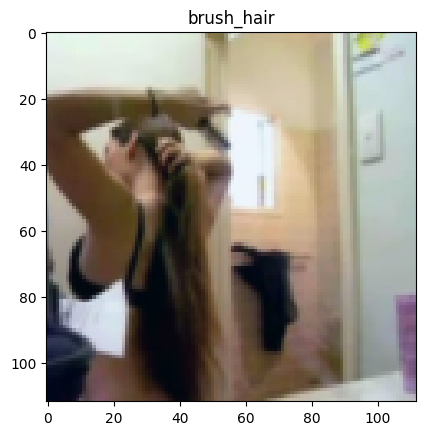

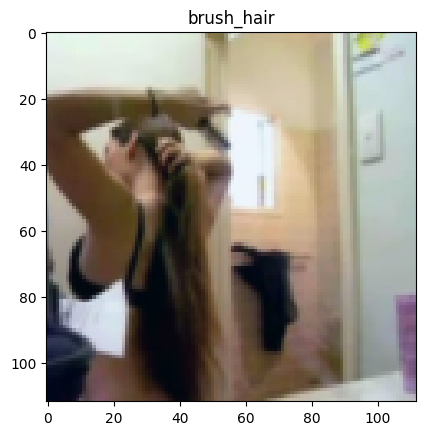

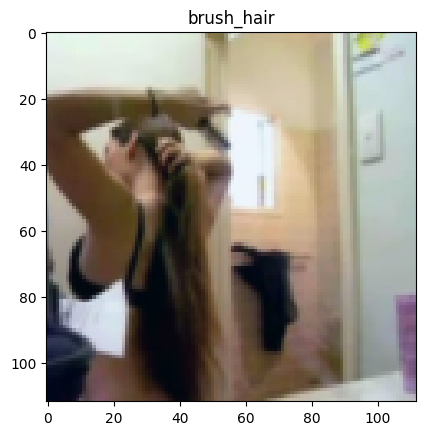

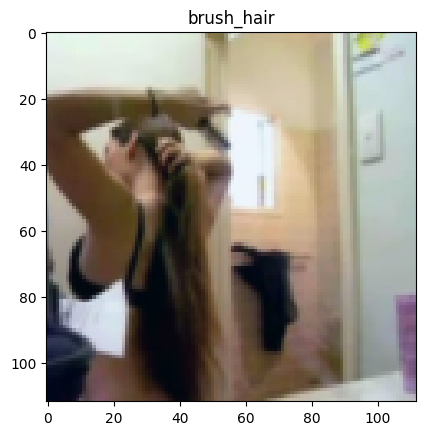

In [36]:
sample1 = x[0].numpy()

frames = np.transpose(sample1[:3, :, :, :], axes=[1, 2, 3, 0])
image = frames[0, :, :, :]

for image in frames:
    # Normalize between 0 and 1
    image = (image-np.min(image))/(np.max(image)-np.min(image))
    plt.figure()
    plt.title(f'{classes[y[0]]}')
    plt.imshow(image)
    plt.show()

## TS Data Analysis

Now we will take a look at the TS sampling and visualization. First set the opt to be using HTSU

In [37]:
opt_ts = dummy()
opt_ts.modality = 'HTSU'
opt_ts.batch_size = 1
opt_ts.n_classes = 51
opt_ts.n_finetune_classes = 51
opt_ts.model = 'resnext'
opt_ts.input_channels = 3
opt_ts.frame_dir = "/scratch/tkg5kq/mmaction2/data/hmdb51/wslices_res/"
opt_ts.annotation_path = "/scratch/tkg5kq/mmaction2/data/hmdb51/annotations/"
model_path = '/scratch/tkg5kq/MARS/results/TS/wslices_400_epochs2/HMDB51/'
model_name = 'PreKin_HMDB51_1_RGB_train_batch32_sample112_clip16_nestFalse_damp0.9_weight_decay1e-05_manualseed1_modelresnext101_ftbeginidx4_varLR400.pth'
opt_ts.resume_path1 = os.path.join(model_path, model_name)
opt_ts.output_layers = ['avgpool', 'layer4', 'layer3']
opt_ts.training = 0

Next upload the data and run the model

In [38]:
ts_data   = HMDB51_test(split = 1, 
                             train = 0, 
                             opt = opt_ts)
print("Length of train data = ", len(ts_data))

Length of train data =  1530


In [39]:
ts_dataloader = DataLoader(ts_data, 
                             batch_size = opt_ts.batch_size, 
                             shuffle=False, 
                             pin_memory = True, 
                             drop_last=True)
print("Length of test datatloader = ",len(ts_dataloader)) 

Length of test datatloader =  1530


In [40]:
ts_batch = next(iter(ts_dataloader))

[7, 56, 72, 89, 100, 154, 168, 176, 198, 226, 266, 280, 284, 285, 296, 307]


In [52]:
# Get TS model
with torch.no_grad():
    ts_model, ts_parameters = generate_model(opt_ts)
    print('loading checkpoint {}'.format(opt.resume_path1))
    checkpoint = torch.load(opt.resume_path1)
    assert opt.arch == checkpoint['arch'], f'Arch needs to be {checkpoint["arch"]}'
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    # run model on generated batch
    x,y = ts_batch
    out = ts_model(x)

    names = ['predictions']
    names.extend(opt_ts.output_layers)
    for element, name in zip(out, names):
        print(f'{name}: {element.shape}')

    pred5 = np.array(torch.mean(out[0], dim=0, keepdim=True).topk(5, 1, True)[1].cpu().data[0])
    print(f'Pred: {[classes[pred] for pred in pred5]}, Actual: {classes[y[0]]}')

loading checkpoint /scratch/tkg5kq/MARS/pretrained/MARS_orig/HMDB/RGB_HMDB51_16f.pth
predictions: torch.Size([1, 51])
avgpool: torch.Size([1, 2048])
layer4: torch.Size([1, 2048, 1, 4, 4])
layer3: torch.Size([1, 1024, 2, 7, 7])
Pred: ['stand', 'swing_baseball', 'talk', 'climb_stairs', 'kick'], Actual: brush_hair


avgpool: torch.Size([1, 51])
layer4: torch.Size([1, 2048])
layer3: torch.Size([1, 2048, 1, 4, 4])


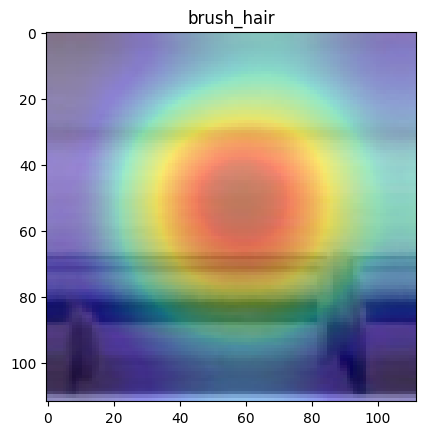

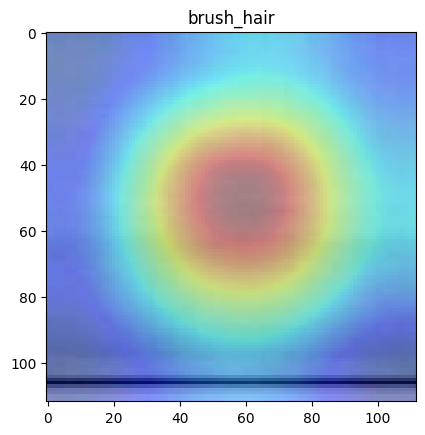

In [42]:
frame_num = -1
sample_num = 0

# Display the sizes of the layers
for i, output_layer in enumerate(opt.output_layers):
    print(f'{output_layer}: {out[i].shape}')

# https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
with torch.no_grad():
    data = out[2].cpu()[sample_num]

    # Interpolate from 4x4 to 112x112
    interp_data = F.interpolate(data, size=(112, 112), mode='bicubic', align_corners=False)
    # squeeze to just 4x4
    heatmap = torch.mean(interp_data, dim=(0,1)).squeeze()

    # Get the frame from the sample input and normalize
    perm_frames = x.permute(0, 2, 3, 4, 1)
    frame = perm_frames[sample_num, perm_frames.shape[1]//2]
    frame = frame.numpy()
    image = (frame-np.min(frame))/(np.max(frame)-np.min(frame))

    plt.figure()
    plt.title(f'{classes[y[sample_num]]}')
    plt.imshow(image)
    plt.imshow(heatmap, 'jet', interpolation='none', alpha=0.4)
    plt.show()

    # Get the frame from the sample input and normalize
    frame = x.permute(0, 2, 3, 4, 1)[sample_num, -1]
    frame = frame.numpy()
    image = (frame-np.min(frame))/(np.max(frame)-np.min(frame))

    plt.figure()
    plt.title(f'{classes[y[sample_num]]}')
    plt.imshow(image)
    plt.imshow(heatmap, 'jet', interpolation='none', alpha=0.4)
    plt.show()

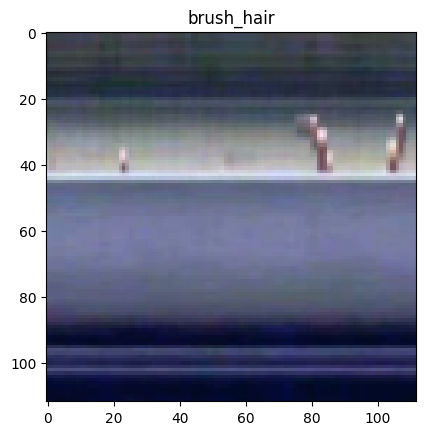

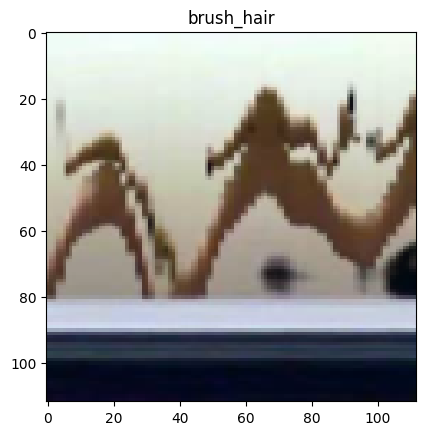

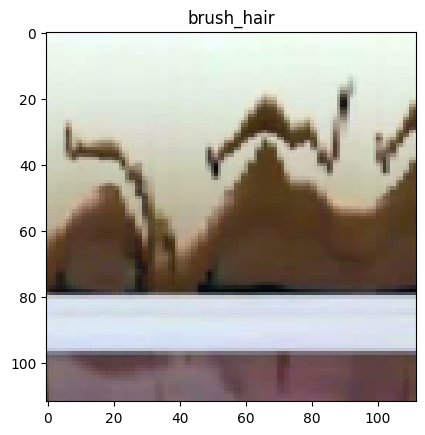

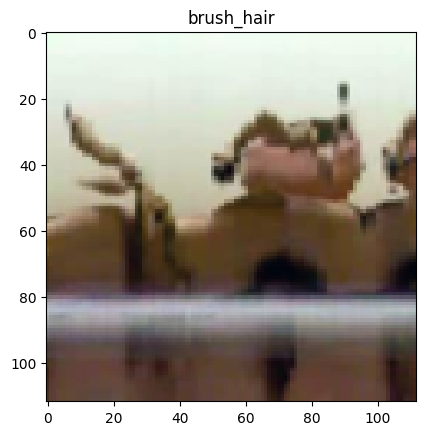

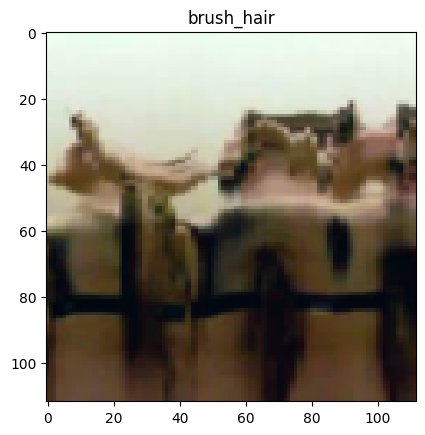

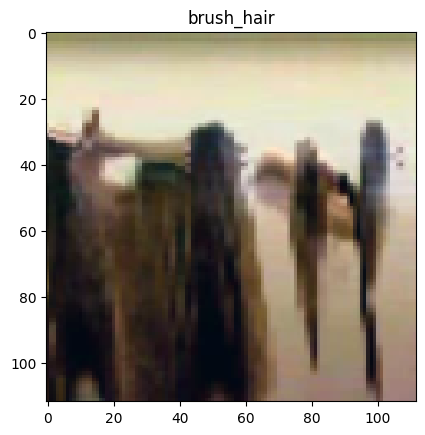

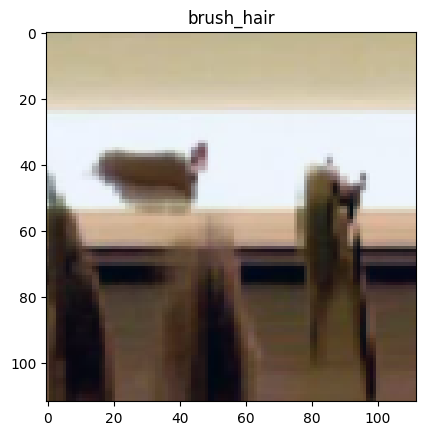

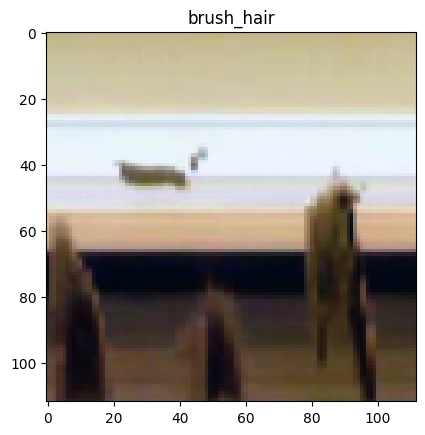

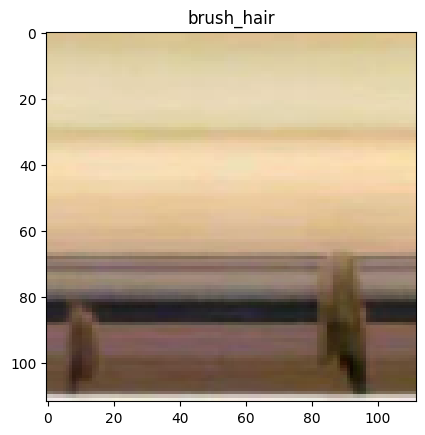

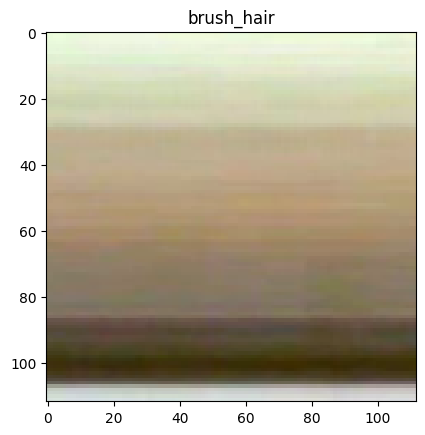

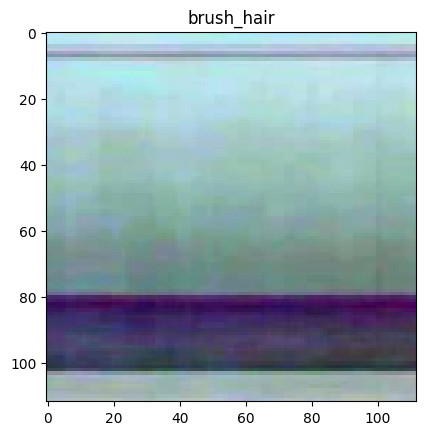

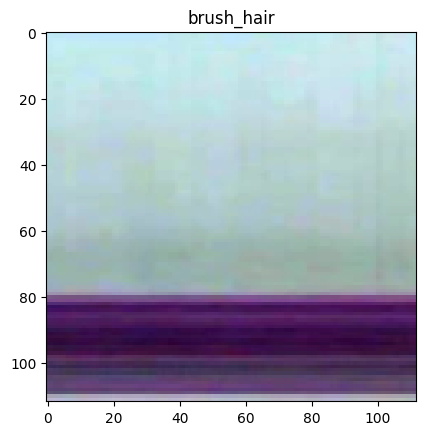

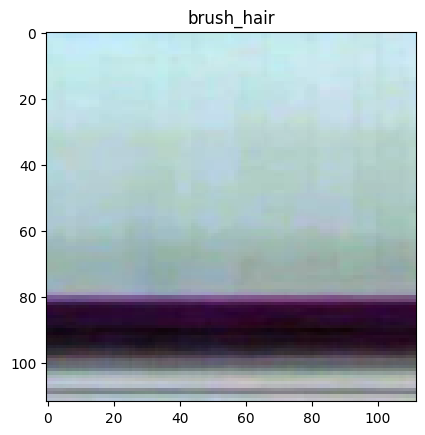

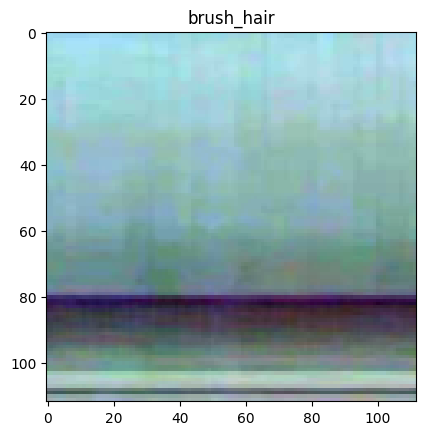

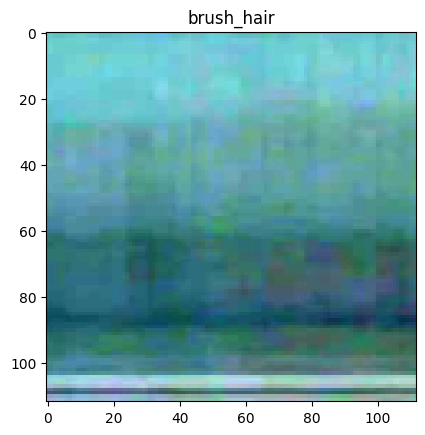

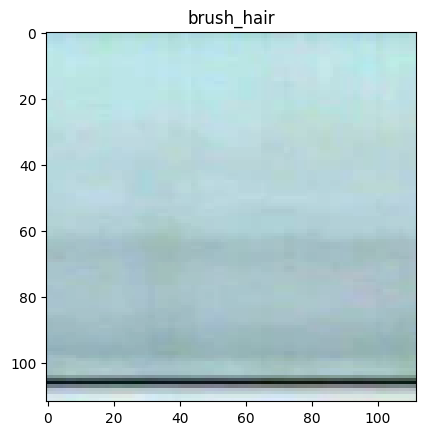

In [43]:
sample1 = x[0].numpy()

frames = np.transpose(sample1[:3, :, :, :], axes=[1, 2, 3, 0])
image = frames[0, :, :, :]

for image in frames:
    # Normalize between 0 and 1
    image = (image-np.min(image))/(np.max(image)-np.min(image))
    plt.figure()
    plt.title(f'{classes[y[0]]}')
    plt.imshow(image)
    plt.show()